In [ ]:

!pip install pyqubo
!pip install rustworkx

!pip install docplex
!pip install qiskit
!pip install qiskit-optimization


In [ ]:
!pip install 'qiskit-optimization[cplex]'

In [7]:
import random

In [8]:
import csv
from shapely.wkt import loads

def parse_csv_file(file_path):
    # Initialize empty lists to store the extracted values
    latitudes = []
    longitudes = []
    names = []

    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present

        for row in reader:
            # Extract the desired fields
            url = row[0]
            object_id = row[1]
            name = row[2]
            geom = loads(row[3])  # Parse the WKT geometry into a Shapely object
            line = row[4]
            notes = row[5]

            # Extract latitude and longitude from the Shapely point
            latitude = geom.y
            longitude = geom.x

            # Append the values to the respective lists
            latitudes.append(latitude)
            longitudes.append(longitude)
            names.append(name)

    return latitudes, longitudes, names

# Path to the CSV file
file_path = './DOITT_SUBWAY_STATION_01_13SEPT2010.csv'

# Call the function to parse the data from the file
latitudes, longitudes, names = parse_csv_file(file_path)

coordinates = {}

for lat, lon, n in zip(latitudes, longitudes, names):
  coordinates[n] = [lat,lon]

print(coordinates)

# we will only consider the first a select number of stations chosen at random
# this is to reduce the number of variables in the problem
# and to reduce the number of edges in the graph
selected_coordinates = {}
random.seed(1234)
# randomly select 10 stations
for i in range(10):
  selected_coordinates[random.choice(list(coordinates.keys()))] = coordinates[random.choice(list(coordinates.keys()))]

{'Astor Pl': [40.73005400028978, -73.99106999861966], 'Canal St': [40.718814263587134, -74.00105471306033], '50th St': [40.76245599925997, -73.98598400026407], 'Bergen St': [40.68611054725977, -73.99075649573565], 'Pennsylvania Ave': [40.66471445143568, -73.89488591154061], '238th St': [40.88466700064975, -73.90087000018522], 'Cathedral Pkwy (110th St)': [40.80396699961484, -73.9668470005456], 'Kingston - Throop Aves': [40.67991899941601, -73.94085899871263], '65th St': [40.74971952935675, -73.8987883783301], '36th St': [40.65514366633887, -74.00354899951809], 'Delancey St - Essex St': [40.71868074219453, -73.98807806807719], 'Van Siclen Ave': [40.67270999906104, -73.8903580002471], 'Norwood Ave': [40.68152000045683, -73.87962599910783], '104th-102nd Sts': [40.69516599823373, -73.84443500029684], 'DeKalb Ave': [40.70369299961644, -73.91823200219723], 'Beach 105th St': [40.58326843810286, -73.82758075034528], 'Beach 90th St': [40.58809156457325, -73.81365140419632], 'Freeman St': [40.82

In [9]:
for (key, value) in selected_coordinates.items():
    print(key, value)

55th St [40.86280299988937, -73.90103399921699]
161st St - Yankee Stadium [40.68611054725977, -73.99075649573565]
Freeman St [40.69225539645323, -73.98605667854612]
34th St - Hudson Yards [40.667883603536815, -73.95058920022207]
Whitlock Ave [40.823976841237396, -73.89306639507903]
Nassau Ave [40.69945400090837, -73.91217899939602]
Beach 105th St [40.74971952935675, -73.8987883783301]
W 4th St - Washington Sq (Upper) [40.74971952935675, -73.8987883783301]
World Trade Center [40.706476001106005, -74.01105599991755]
Prince St [40.816029252510006, -73.91779152760981]


In [10]:
stations_dic = {}
input_file_path = "stations.csv"

with open(input_file_path, "r") as input_file:
    next(input_file, None)
    for line in input_file:
        fields = line.strip().split(",")
        start = fields[0]
        end = fields[1]
        duration = float(fields[2])
        key = (start, end)
        stations_dic[key] = duration


In [13]:
# calculate the f and g for each station
# f is the number of people getting off at the station
# g is the distance from the nearest touristic site

def get_no_of_people_at_station(selected_coordinates):
    pop_at_station = {}
    with open("station_pop.csv", "r") as input_file:
        next(input_file, None)
        for line in input_file:
            fields = line.strip().split(",")
            station = fields[0]
            pop = float(fields[1])
            if station in selected_coordinates.keys():
                pop_at_station[station] = pop
    
    return pop_at_station

def get_distance_from_nearest_site(selected_coordinates):
    distance_from_site = {}
    with open("site_distance.csv", "r") as input_file:
        next(input_file, None)
        for line in input_file:
            fields = line.strip().split(",")
            station = fields[0]
            distance = float(fields[1])
            if station in selected_coordinates.keys():
                distance_from_site[station] = distance
    
    return distance_from_site

def normalize(dic):
    max_value = max(dic.values())
    min_value = min(dic.values())
    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / (max_value - min_value)
    return dic

In [26]:
#node dictionary
node_dic = {}
f_list = get_no_of_people_at_station(selected_coordinates)
g_list = get_distance_from_nearest_site(selected_coordinates)

f_list = normalize(f_list)
g_list = normalize(g_list)

print(f_list)

for (key, _) in selected_coordinates.items():
  print(key)
  node_dic[key] = { 'name':key , 'f': f_list[key] , 'g': g_list[key]}

C = 2
D = 2

temp = {node: {"name": attrs["name"], "c": C*attrs["f"] + D*attrs["g"]}
                 for node, attrs in node_dic.items()}
node_dic = temp

#node index dictionary
index_dic = {}

index = 0
for node in node_dic:
  index_dic[node] = index
  index+=1

# #edge dictionary
# edge_dic = {}

# # edges only between nodes w 30 min distance
# for item in stations_dic.items():
#   dur = item[1]
#   if dur <= 30:
#     edge_dic[item[0]] = {'cost': dur}

# will add edges for all the nodes considered
edge_dic = {}
for item in stations_dic.items():
  if (item[0][0] in node_dic) and (item[0][1] in node_dic) and (item[1] <= 100):
    edge_dic[item[0]] = {'cost': item[1]}

{'55th St': 0.26235268973264214, '161st St - Yankee Stadium': 0.0776575492939545, 'Freeman St': 0.4051523179466278, '34th St - Hudson Yards': 0.5619585369126849, 'Whitlock Ave': 0.043073497323438924, 'Nassau Ave': 0.0, 'Beach 105th St': 0.12669055772872545, 'W 4th St - Washington Sq (Upper)': 0.9692729794076276, 'World Trade Center': 1.0, 'Prince St': 0.5624058730261294}
55th St
161st St - Yankee Stadium
Freeman St
34th St - Hudson Yards
Whitlock Ave
Nassau Ave
Beach 105th St
W 4th St - Washington Sq (Upper)
World Trade Center
Prince St


**API to calculate distance between nodes (stations)**


In [23]:
# import requests
# import csv

# # Create and write to the CSV file
# with open("/content/output.csv", mode="w", newline="") as file:
#       writer = csv.writer(file)
#       writer.writerow(["start", "end", "duration (mins)"])


# with open("/content/output.csv", mode="a", newline="") as file:
#     writer = csv.writer(file)

#     for start in coordinates.items():
#       start_lat = start[1][0]
#       start_lon = start[1][1]
#       start_name = start[0]
#       print(start_name)
#       for end in coordinates.items():

#         end_name = end[0]
#         if end_name == start_name:
#           continue

#         end_lat = end[1][0]
#         end_lon = end[1][1]

#         url = f"https://api.mapbox.com/directions/v5/mapbox/cycling/{start_lon}%2C{start_lat}%3B{end_lon}%2C{end_lat}?alternatives=false&annotations=distance%2Cduration&continue_straight=true&geometries=geojson&overview=full&steps=false&access_token=pk.eyJ1Ijoic2FzaGEtc3NtOTk2MCIsImEiOiJjbG4wcm9saG8xc3duMmlxd3pjY2MybDcyIn0.ol8PlZNYBX_XbtBu8I3igw"

#         try:
#             r = requests.get(url)
#             r.raise_for_status()  # Raise an exception for bad response status
#             dur = r.json()['routes'][0]['duration'] / 60  # Duration in minutes

#         # Write the record to the CSV file immediately after receiving the response
#             writer.writerow([start_name, end_name, dur])
#         except requests.exceptions.RequestException as e:
#             print(f"Error making API request: {e}")


# print("CSV file 'output.csv' has been created and populated with data.")


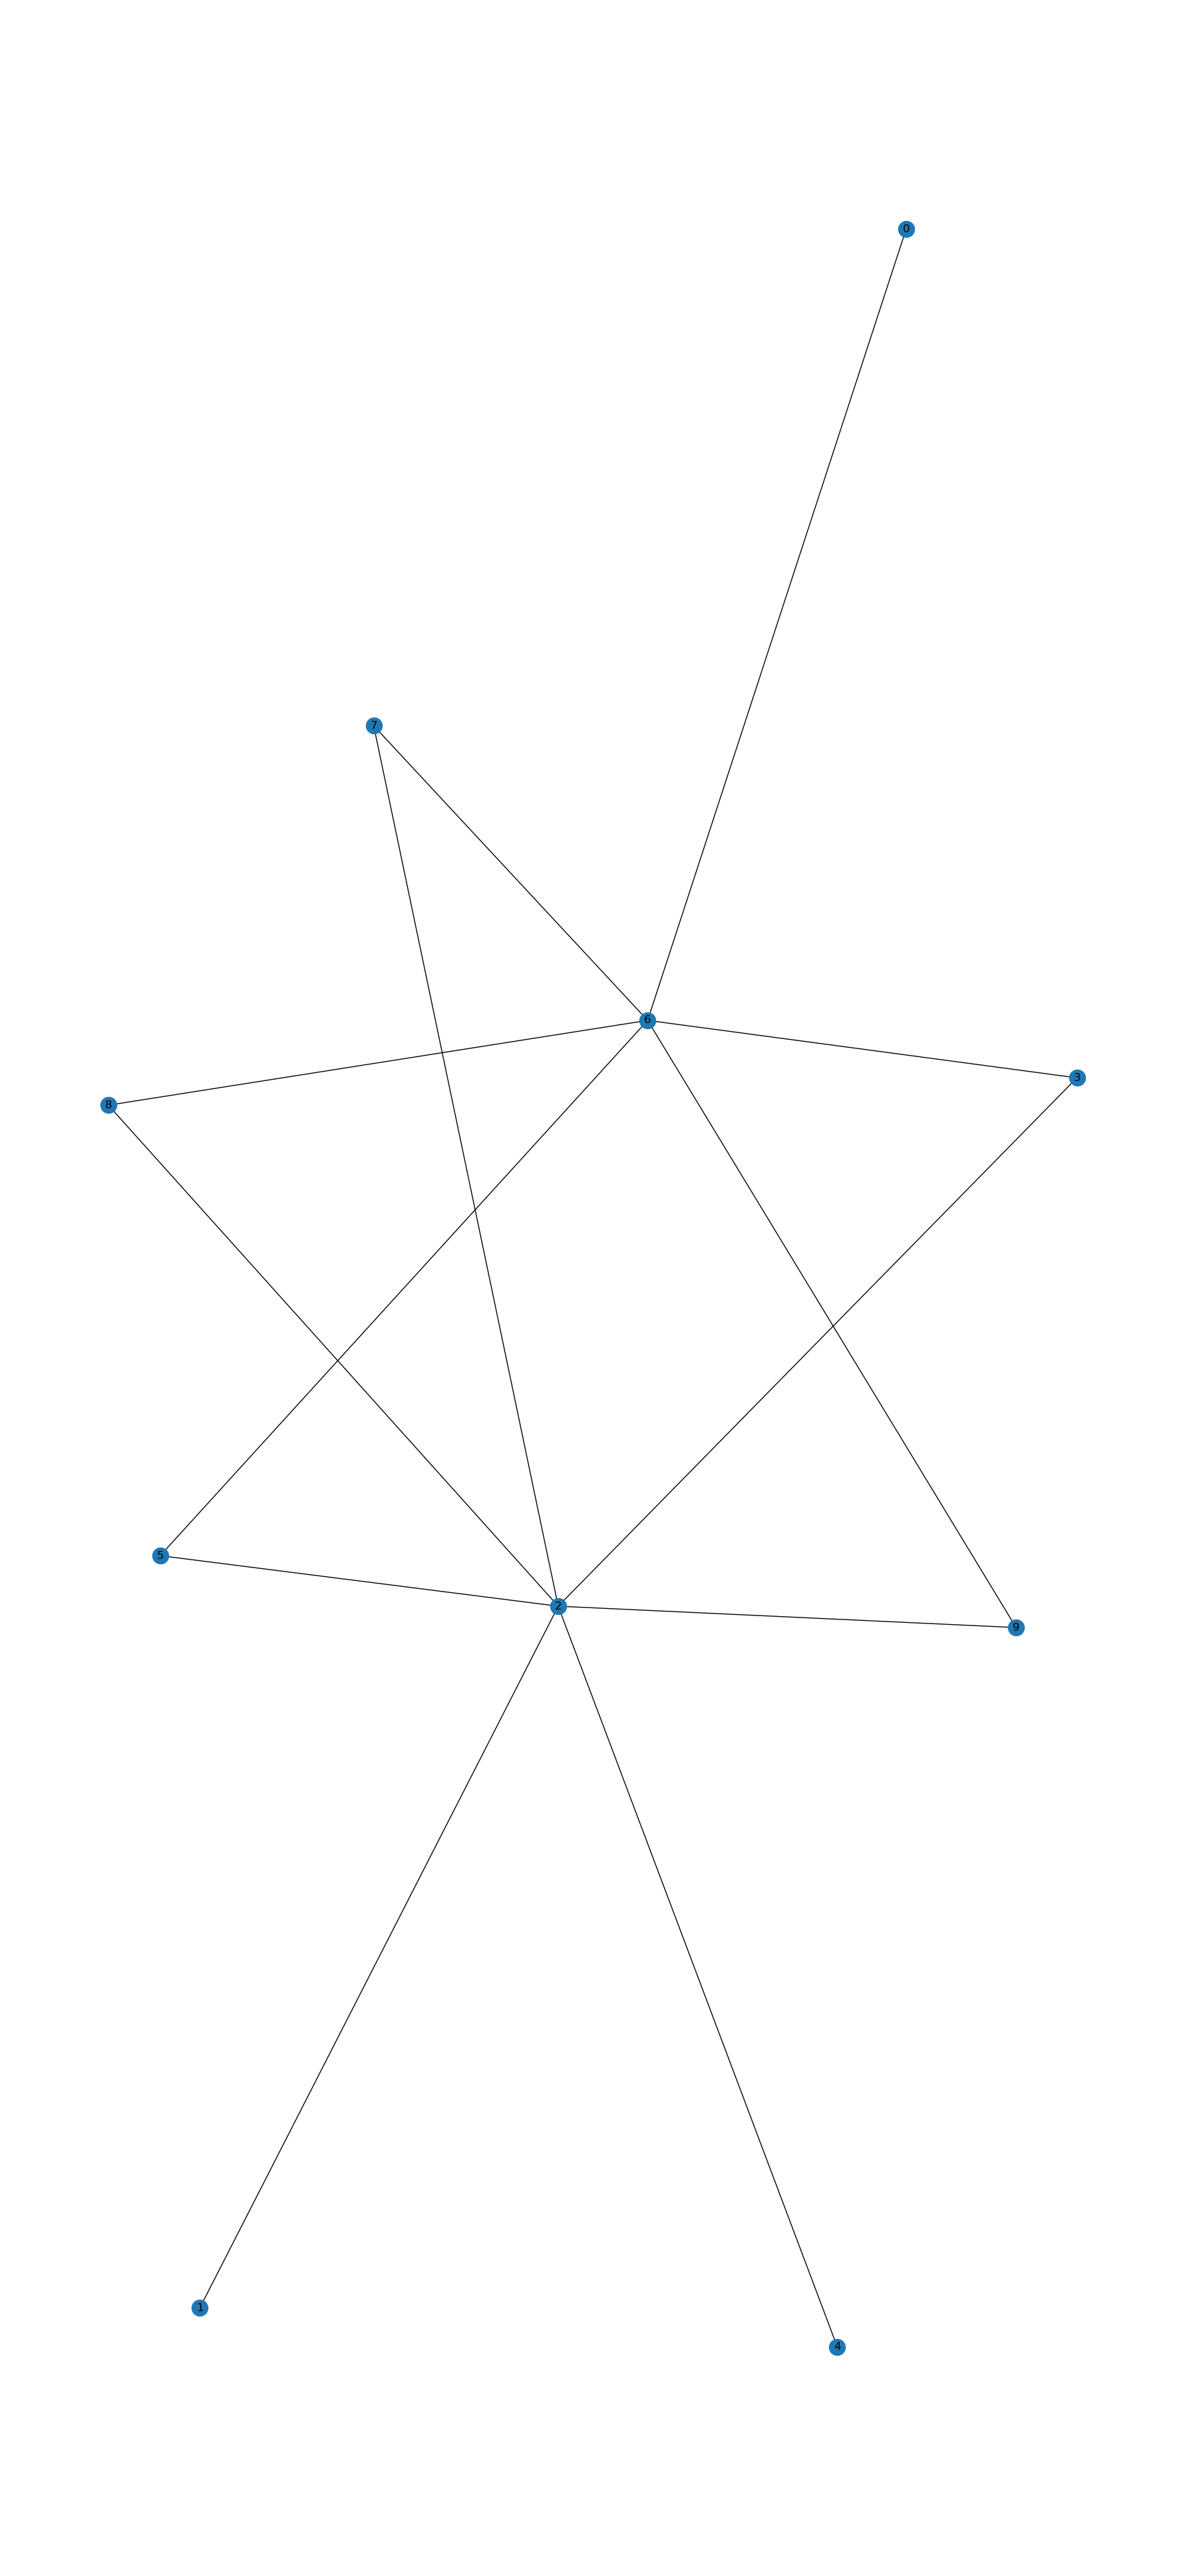

In [27]:
import rustworkx
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw

graph = rustworkx.PyGraph()

for node in node_dic.items():
  graph.add_node(node[1])

for edge in edge_dic.items():
  graph.add_edge( index_dic[edge[0][0]] , index_dic[edge[0][1]] , edge[1]["cost"])

# Calculate the betweenness centrality for each node
bw_centrality = rustworkx.betweenness_centrality(graph)

# Create a larger figure with a specified size (adjust the values as needed)
fig = plt.figure(figsize=(50, 50))

# Create a subplot within the larger figure
subax1 = plt.subplot(121)

# Now, you can draw your graph with_labels=True on the larger subplot
mpl_draw(graph, with_labels=True, ax=subax1)

# Show the plot
plt.show()

Visualizing Centraliy

In [22]:
import matplotlib.pyplot as plt

# Generate a color list
colors = []
for node in graph.node_indices():
    colors.append(bw_centrality[node])

# Create a larger figure with a specified size
plt.figure(figsize=(200, 200))

# Generate a visualization with a colorbar
plt.rcParams['figure.figsize'] = [15, 10]
ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=plt.Normalize(
    vmin=min(bw_centrality.values()),
    vmax=max(bw_centrality.values())
))
plt.colorbar(sm, ax=ax)
plt.title("Betweenness Centrality of a 4 x 4 Hexagonal Lattice Graph")

# Draw the graph with enlarged size
mpl_draw(graph, node_color=colors, ax=ax)

# Show the plot
plt.show()


In [29]:
####################################################################
#Formulating and solving a Hamiltonian from a given rustworkx graph#
####################################################################

from pyqubo import Binary
from pyqubo import Array
from pprint import pprint
import neal

nodes = len(node_dic)

#create an array of binary variables in our Hamiltonian.
#x[i] = 1 if a sensor is placed at that node, 0 otherwise
x = Array.create('x', shape=(nodes), vartype='BINARY')

#####calculate H_1#####
H_1 = 0
weight_max = None

for edge in graph.edge_list():

  # here weight (cost) is betweenness centrality of nodes in the edge
  weight = bw_centrality[edge[0]] + bw_centrality[edge[1]]

  if weight_max is None or weight > weight_max:
    weight_max = weight

  H_1 += (1-x[edge[0]])*(1-x[edge[1]])*weight

H_1 *= 1/weight_max

#####calculate H_2#####
H_2 = 0

for i in range(len(index_dic)):
  # here cost c = Cf(i) + Dg(i)
  cost = graph[i]["c"]
  H_2 += x[i]*cost

#####calculate H_3#####

#number of sensors we want to place
stations = 4
H_3 = (sum(x)-stations)**2

#####Get Hamiltonian function#####
A,B,C = 100,100,100 #random coef for now
H = A*H_1 + B*H_2 + C*H_3

#Compile the Hamiltonian to get a model
model = H.compile()

#get and print QUBO coefficients
qubo, offset = model.to_qubo()
#print("Printing QUBO coefficients:")
#pprint(qubo)

#Solve BinaryQuadraticModel(BQM) by using Sampler class
bqm = model.to_bqm()

#get the solutions of QUBO as SampleSet
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=1000)

#interpret the sampleset object
decoded_samples = model.decode_sampleset(sampleset)
#print the decoded_samples
#print("Printing the decoded sample:")
#pprint(decoded_samples)

best_sample = min(decoded_samples, key=lambda x: x.energy)

#print the best sample
print("Printing the best sample:")
pprint(best_sample.sample)

Printing the best sample:
{'x[0]': 1,
 'x[1]': 1,
 'x[2]': 1,
 'x[3]': 0,
 'x[4]': 0,
 'x[5]': 0,
 'x[6]': 1,
 'x[7]': 0,
 'x[8]': 0,
 'x[9]': 0}
